In [15]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)
# library(ggpubr)

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Make a similar color blind palette, but with dark red for stop codons
print(cbPalette)
stopPalette <- c("#999999", "#E69F00", "#E0115F", "#FF0000", "#000000")
print(stopPalette)



[1] "#999999" "#E69F00" "#56B4E9" "#009E73" "#F0E442" "#0072B2" "#D55E00"
[8] "#CC79A7"
[1] "#999999" "#E69F00" "#E0115F" "#FF0000" "#000000"


## Read in sample annotations

In [2]:
ix_barcode_annotations <- read_csv("../annotations/illumina_info.csv") %>% 
  select(sample_name, index_barcode, diagonal, expression, replicate, sampletype) %>% 
  mutate(sample_name = fct_reorder(sample_name, as.integer(str_extract(sample_name, "[:digit:]+$")))) %>% 
  print()

Rows: 10 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): pool_name, sample_name, barcode1, Sequencing Primer, Sample Type, ...
dbl  (3): Pool Conc. (nM), Pool Size, replicate
lgl  (1): barcode2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 10 × 6
   sample_name index_barcode diagonal expression replicate sampletype
   <fct>       <chr>         <chr>    <chr>          <dbl> <chr>     
 1 104p1       CTGATC        on       high               1 grna      
 2 104p2       AAGCTA        on       low                1 grna      
 3 104p3       GTAGCC        off      high               1 grna      
 4 104p4       TACAAG        off      low                1 grna      
 5 104p5       TTGACT        on       high               2 grna      
 6 104p6       GGAACT        on       low                2 grna      
 7 104p7       TGACAT        off      high               2 grna      
 8 104p8       GGACGG        off      low                2 grna      
 9 104p9       CTCTAC        unsorted unsorted           1 grna      
10 104p10      GCGGAC        unsorted unsorted           1 gdna      


## Read insert annotations

In [3]:
insert_annotations <- read_tsv("../../pool1_linkage/annotations/insert_annotations/dicodon_linkage.tsv") %>% 
  select(insert_num, insert) %>%  
  # Inidcate repetitive dicodon inserts  
  mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
  # calculate gc3
  bind_cols(DNAStringSet(.$insert) %>% 
              subseq(start=3) %>% 
              oligonucleotideFrequency(1, 3) %>% 
              as_tibble() %>% 
              rename_all(. %>% paste0("3")) %>% 
              mutate(gc3 = (G3 + C3) / (A3 + C3 + G3 + T3)) %>% 
              select(gc3)
            ) %>% 
  # calculate gc
  bind_cols(DNAStringSet(.$insert) %>% 
              oligonucleotideFrequency(1, 1) %>% 
              as_tibble() %>% 
              mutate(gc = (G + C) / (A + C + G + T)) %>% 
              select(gc)
            ) 

dicodon_annotations <- insert_annotations %>% 
  filter(!is.na(dicodon)) %>% 
  mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
  mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  print()

non8xinsert_annotations <- insert_annotations %>% 
  filter(is.na(dicodon)) %>% 
  select(-dicodon) %>% 
  print()

Rows: 6000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): group, insert, seq
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 10
   insert_num insert         dicodon   gc3    gc diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>          <chr>   <dbl> <dbl> <chr> <chr>  <chr>  <chr> <chr>
 1       4095 TTTTTTTTTTTTT… TTTTTT    0   0     FF    TTT    TTT    F     F    
 2       4094 TTTTTGTTTTTGT… TTTTTG    0.5 0.167 FL    TTT    TTG    F     L    
 3       4093 TTTTTCTTTTTCT… TTTTTC    0.5 0.167 FF    TTT    TTC    F     F    
 4       4092 TTTTTATTTTTAT… TTTTTA    0   0     FL    TTT    TTA    F     L    
 5       4091 TTTTGTTTTTGTT… TTTTGT    0   0.167 FC    TTT    TGT    F     C    
 6       4090 TTTTGGTTTTGGT… TTTTGG    0.5 0.333 FW    TTT    TGG    F     W    
 7       4089 TTTTGCTTTTGCT… TTTTGC    0.5 0.333 FC    TTT    TGC    F     C    
 8       4088 TTTTGATTTTGAT… TTTTGA    0   0.167 F*    TTT    TGA    F     *    
 9       4087 TTTTCTTTTTCTT… TTTTCT    0   0.167 FS    TTT    TCT    F     S    
10       4086 TTTTCGTTTTCGT… TTTTCG    0.5 0.333 FS    TTT    TCG    F     S    
# … w

## Read in insert + barcode read count data

In [4]:
barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% 
  select(-linkage_count, - linkage_ref, -library_type, -linkage_ref, -sample_name) %>%
  dplyr::rename(sample_name = sample_id) %>%
  print()

Rows: 646204 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): sample_id, sample_name, library_type, linkage_ref
dbl (4): insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 646,204 × 4
   sample_name insert_num barcode_num barcode_count
   <chr>            <dbl>       <dbl>         <dbl>
 1 104p3              696      249880          3970
 2 104p3              514      398088          3734
 3 104p3              687       88292          2820
 4 104p3             5308      423688          2801
 5 104p3             3629      317485          2651
 6 104p3             4915      430480          2462
 7 104p3             3842        1303          2452
 8 104p3             2939      393860          2296
 9 104p3             3491      396693          2178
10 104p3               10      358101          2083
# … with 646,194 more rows


## Sum barcode counts and pivot for downstream plottiong

In [8]:
summed_barcodes <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup()

summed_barcodes

insert_counts <- summed_barcodes %>%
  # select(sample_name, count) %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes"), values_fill = list("count" = 0, "n_barcodes" = 0)) %>% 
  inner_join(select(insert_annotations, insert_num), by = "insert_num") %>% print 

insert_counts

`summarise()` has grouped output by 'insert_num'. You can override using the
`.groups` argument.


insert_num,sample_name,count,n_barcodes
<dbl>,<chr>,<dbl>,<int>
0,104p1,1055,14
0,104p10,780,6
0,104p2,853,18
0,104p3,2146,42
0,104p4,1335,28
⋮,⋮,⋮,⋮
5999,104p5,611,13
5999,104p6,601,12
5999,104p7,243,9


# A tibble: 5,845 × 21
   insert_num count_10…¹ count…² count…³ count…⁴ count…⁵ count…⁶ count…⁷ count…⁸
        <dbl>      <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1          0       1055     780     853    2146    1335     660     899     835
 2          1       4347    1744    6240    1667     620    3795    6615     912
 3          2        823    2781    1936    5526    6768     335    2163    4179
 4          3       1926    1705    3998     987      50    1171    2051     467
 5          4       1960    1756    6356    1501     509    1912    6138     420
 6          5       1984    2313    2405    1279     502    1814    3690     847
 7          6       1094     811    2491     591     419     997    2172     635
 8          7        808     783    1094    1319     760    1164    1341     966
 9          8       2523    1614    4187    6570     707    3049    5262    3685
10          9       2726     438    2223     846     473    1882    2657     715
# … w

insert_num,count_104p1,count_104p10,count_104p2,count_104p3,count_104p4,count_104p5,count_104p6,count_104p7,count_104p8,⋯,n_barcodes_104p1,n_barcodes_104p10,n_barcodes_104p2,n_barcodes_104p3,n_barcodes_104p4,n_barcodes_104p5,n_barcodes_104p6,n_barcodes_104p7,n_barcodes_104p8,n_barcodes_104p9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,1055,780,853,2146,1335,660,899,835,1304,⋯,14,6,18,42,28,15,15,33,32,36
1,4347,1744,6240,1667,620,3795,6615,912,734,⋯,39,14,63,28,10,45,50,23,11,46
2,823,2781,1936,5526,6768,335,2163,4179,5027,⋯,11,8,18,42,30,11,21,36,32,39
3,1926,1705,3998,987,50,1171,2051,467,18,⋯,22,6,30,16,2,21,35,14,2,29
4,1960,1756,6356,1501,509,1912,6138,420,330,⋯,19,10,39,18,5,24,37,9,5,32
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5995,874,293,1222,725,153,806,952,198,0,⋯,13,4,11,15,2,13,17,5,0,10
5996,2009,1109,1378,1078,315,1284,2043,745,173,⋯,31,6,27,18,4,34,35,19,4,34
5997,1660,413,1558,317,66,1255,1846,164,24,⋯,17,3,23,8,2,19,20,7,2,19


## Join annotations to summed count data

- Of note, count numbers appear slightly different than in my original analysis. Prehaps we're missing a read-count cutoff in the ealier read processing steps?

In [9]:
join_data <- insert_counts %>% 
  pivot_longer(-insert_num, names_to = c(".value", "sample_name"), names_pattern = "(.+)_(.+)") %>% 
  right_join(dicodon_annotations, by = "insert_num") %>% 
  group_by(sample_name, diaa) %>% 
  summarize(count = sum(count), n_barcodes = sum(n_barcodes)) %>% 
  ungroup() %>% 
  left_join(ix_barcode_annotations, by = "sample_name") %>% print 

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


# A tibble: 4,460 × 9
   sample_name diaa  count n_barcodes index_ba…¹ diago…² expre…³ repli…⁴ sampl…⁵
   <chr>       <chr> <dbl>      <int> <chr>      <chr>   <chr>     <dbl> <chr>  
 1 104p1       **     9245         76 CTGATC     on      high          1 grna   
 2 104p1       *A     6303         83 CTGATC     on      high          1 grna   
 3 104p1       *C     3751         32 CTGATC     on      high          1 grna   
 4 104p1       *D     4402         54 CTGATC     on      high          1 grna   
 5 104p1       *E     5022         27 CTGATC     on      high          1 grna   
 6 104p1       *F     2953         47 CTGATC     on      high          1 grna   
 7 104p1       *G     7752         58 CTGATC     on      high          1 grna   
 8 104p1       *H     4131         63 CTGATC     on      high          1 grna   
 9 104p1       *I     4766         77 CTGATC     on      high          1 grna   
10 104p1       *K     2111         31 CTGATC     on      high          1 grna   
# … wi

## Compare non-selected and low YFP (off-low) populations

- Although count numbers differ slightly from initial analysis, replicates still agree with each other nicely. 
- Plot looks about the same as previously; maybe a but tighter correlation, in fact. 

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


# A tibble: 425 × 9
   diaa  count_off_1 count_off_2 count…¹ n_bar…² n_bar…³ n_bar…⁴ lfc_o…⁵ lfc_o…⁶
   <chr>       <dbl>       <dbl>   <dbl>   <int>   <int>   <int>   <dbl>   <dbl>
 1 *W           6615        5518    2254      35      31      31    2.93    3.04
 2 F*          22203       17760    8443     180     166     136    2.77    2.82
 3 *Q          19328       17718    8402     153     143     129    2.58    2.82
 4 *F          15736       14463    6861     143     146     130    2.58    2.82
 5 N*          22012       17112    9220     184     166     174    2.63    2.64
 6 *N          19067       14471    7936     179     151     170    2.64    2.61
 7 *Y          25845       21088   11155     211     203     202    2.59    2.66
 8 *P          29522       23087   12523     297     259     273    2.62    2.63
 9 *L          61504       44106   25700     433     384     403    2.64    2.53
10 *C          12270       10394    5682     124     118     108    2.49    2.62
# … with

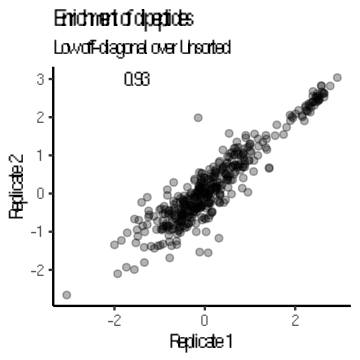

In [11]:
options(repr.plot.width=3, repr.plot.height=3)

plot_data <- insert_counts %>% 
  pivot_longer(-insert_num, names_to = c(".value", "sample_name"), names_pattern = "(.+)_(.+)") %>% 
  right_join(dicodon_annotations, by = "insert_num") %>% 
  group_by(sample_name, diaa) %>% 
  summarize(count = sum(count), n_barcodes = sum(n_barcodes)) %>% 
  ungroup() %>% 
  left_join(ix_barcode_annotations, by = "sample_name") %>%
  filter((diagonal == "off" & expression == "low")|(diagonal == "unsorted" & sampletype == "grna")) %>%
  select(-index_barcode, -sample_name, -sampletype, -expression) %>%
  arrange(diaa) %>% 
  pivot_wider(names_from = c("diagonal", "replicate"), values_from = c("count", "n_barcodes"), values_fill = list("count" = 0, "n_barcodes" = 0)) %>%
  mutate(lfc_off_low_vs_unsorted_1 = log2(count_off_1 / count_unsorted_1),
         lfc_off_low_vs_unsorted_2 = log2(count_off_2 / count_unsorted_1)
         ) %>%
  filter(!is.infinite(lfc_off_low_vs_unsorted_1), !is.infinite(lfc_off_low_vs_unsorted_2)) %>%
  filter(n_barcodes_off_1 >= 5, n_barcodes_off_2 >= 5) %>%
  mutate(lfc_off_low_vs_unsorted_1 = lfc_off_low_vs_unsorted_1 - median(lfc_off_low_vs_unsorted_1)) %>%
  mutate(lfc_off_low_vs_unsorted_2 = lfc_off_low_vs_unsorted_2 - median(lfc_off_low_vs_unsorted_2)) %>%
  # select(diaa, lfc_off_low_vs_unsorted_1, lfc_off_low_vs_unsorted_2) %>%
  arrange(-(lfc_off_low_vs_unsorted_1 + lfc_off_low_vs_unsorted_2)) %>%
  # write_tsv("../tables/20201018_off_low_vs_unsorted_dipeptides.tsv") %>%
  print()

correlation <- plot_data %>%
  summarize(rho = round(cor(lfc_off_low_vs_unsorted_1, lfc_off_low_vs_unsorted_2), 2))

plot_data %>%
  ggplot(aes(x = lfc_off_low_vs_unsorted_1, y = lfc_off_low_vs_unsorted_2)) +
  geom_point(alpha = 0.3) +
  geom_text(aes(label = rho), x = -1.5, y = 3, data = correlation) +
  theme_classic() +
  labs(x = "Replicate 1", y = "Replicate 2",
       title = "Enrichment of dipeptides",
       subtitle = "Low off-diagonal over Unsorted")

# Plot stop codons _and_ destabilizing pairs

- Plots look okay as scatters. Better as boxplots. 
- Could subset groups by LFC from the 8x library.

# A tibble: 425 × 11
   diaa  count_o…¹ count…² count…³ n_bar…⁴ n_bar…⁵ n_bar…⁶ lfc_o…⁷ lfc_o…⁸   lfc
   <chr>     <dbl>   <dbl>   <dbl>   <int>   <int>   <int>   <dbl>   <dbl> <dbl>
 1 *W         6615    5518    2254      35      31      31    2.93    3.04  2.93
 2 F*        22203   17760    8443     180     166     136    2.77    2.82  2.77
 3 *Q        19328   17718    8402     153     143     129    2.58    2.82  2.58
 4 *F        15736   14463    6861     143     146     130    2.58    2.82  2.58
 5 N*        22012   17112    9220     184     166     174    2.63    2.64  2.63
 6 *N        19067   14471    7936     179     151     170    2.64    2.61  2.64
 7 *Y        25845   21088   11155     211     203     202    2.59    2.66  2.59
 8 *P        29522   23087   12523     297     259     273    2.62    2.63  2.62
 9 *L        61504   44106   25700     433     384     403    2.64    2.53  2.64
10 *C        12270   10394    5682     124     118     108    2.49    2.62  2.49
# … wit

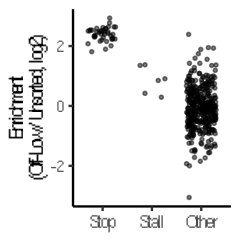

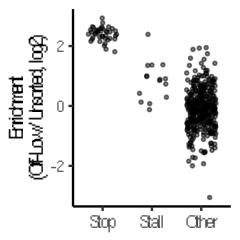

In [12]:
options(repr.plot.width=2, repr.plot.height=2)

# Plot specific inserts
plot_data_2 <- plot_data %>% 
  # Look specifically a the rep#1 enrichment, instead of averaging both reps
  mutate(lfc = (lfc_off_low_vs_unsorted_1)) %>%  
# mutate(lfc = (lfc_off_low_vs_unsorted_1 + lfc_off_low_vs_unsorted_2)/2) %>% 
# mutate(stop = if_else(str_detect(diaa, "\\*"), "Stop", "Others")) %>% 
  mutate(type = case_when(str_detect(diaa, "\\*") ~ "Stop", 
                           str_detect(diaa, "RH|VK|SF|HR|KV|FS") ~ "Stall", 
                           !str_detect(diaa, "\\*|RH|VK|SF|HR|KV|FS") ~ "Other")) %>% print 

plot_data_2 %>% 
  ggplot(aes(x = fct_rev(type), y = lfc)) +
  geom_jitter(width = 0.3, alpha = 0.5, size = 0.5, height = 0) +
  theme_classic() +
  theme(axis.text.x = element_text(size = 10)) +
  labs(x = NULL, y = "Enrichment\n(Off-Low / Unsorted, log2)") +
  NULL

# Okay, now same plot but pick all destabilizing inserts 
# We can do this by joining lfc data from the 8x lilbrary to this dataset. 
# alternatively, pick all inserts from Fig2C: RF, KF, II, VK, LG, SF, YK, KI, RH
# "RF|KF|II|VK|LG|SF|YK|KI|RH"
# "RF|FR|KF|FK|II|VK|KV|LG|GL|SF|FS|YK|KY|RH|HR"
plot_data_3 <- plot_data %>% 
  mutate(lfc = (lfc_off_low_vs_unsorted_1)) %>%  
  mutate(type = case_when(str_detect(diaa, "\\*") ~ "Stop", 
                           str_detect(diaa, "RF|FR|KF|FK|II|VK|KV|LG|GL|SF|FS|YK|KY|RH|HR") ~ "Stall", 
                           !str_detect(diaa, "\\*RF|FR|KF|FK|II|VK|KV|LG|GL|SF|FS|YK|KY|RH|HR") ~ "Other")) %>% print 

plot_data_3 %>% 
  ggplot(aes(x = fct_rev(type), y = lfc)) +
  geom_jitter(width = 0.3, alpha = 0.5, size = 0.5, height = 0) +
  theme_classic() +
  theme(axis.text.x = element_text(size = 10)) +
  labs(x = NULL, y = "Enrichment\n(Off-Low / Unsorted, log2)") +
  NULL

# Not super compelling as a scatter plot, but maybe a box+whisker or violin would work. 
# I think subsetting by lfc value is a very good idea though. Logical followup to fig1. 

## Read in mRNA stability values for each 8x insert

In [13]:

# Read in mRNA level effects from the Pool1 barcodeseq analysis
dipeptide_lfc <- read_tsv("../../pool1_mrna/tables/8xdipeptide_lfc.tsv.gz") %>% print %>% 
  select(diaa, lfc) %>% 
  dplyr::rename(lfc_mrna = lfc) %>% print 


Rows: 441 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): dicodon, diaa, codon1, codon2, aa1, aa2
dbl (6): insert_num, count_grna, count_mrna, n_barcodes_grna, n_barcodes_mrn...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 441 × 12
   insert_num dicodon diaa  codon1 codon2 aa1   aa2   count_grna count…¹ n_bar…²
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>      <dbl>   <dbl>   <dbl>
 1       2608 GGATAA  G*    GGA    TAA    G     *         178222   22193     146
 2       3136 TACAAA  YK    TAC    AAA    Y     K          96768   15509     104
 3        529 AGACAC  RH    AGA    CAC    R     H         125059   20163     180
 4        304 ACATAA  T*    ACA    TAA    T     *         309339   59506     360
 5       1096 CACAGA  HR    CAC    AGA    H     R         159427   31199     249
 6        560 AGATAA  R*    AGA    TAA    R     *         234307   48011     277
 7        780 ATAATA  II    ATA    ATA    I     I         197432   40966     206
 8       2816 GTAAAA  VK    GTA    AAA    V     K         106782   22871     137
 9         44 AAAGTA  KV    AAA    GTA    K     V         169872   36908     226
10         12 AAAATA  KI    AAA    ATA    K     I          71876   16166     110
# … wit

## Pick plotting populations based on dipeptide lfc 

- Based on inital plotting, selevting inserts with < -1.5 mRNA_lfc yeilds only 11 inserts that aren't stop codons. However, they're pretty tightly enriched off-diagonal, which is great.

- Selecting inserts with < -1 (a 2-fold effect) gives a larger spread, but also more inserts. 

- If we set the cuttof to < -1.4 (to include FS) the plot looks very clean except for one weird outlier (insert = FR), which is 1.5 enriched on-diagonal. I think this FR enrichment is a fluke; it goes away if you average FACS reps #1 and #2. But it actually does look a little odd when plotting rep#1, from the perspective that F+R should cause the effects we're looking for. 

- From a paper plotting perspective, rather than fucking around with the cuttof a bunch, I think using a mrna_lfc <= -1 (a 2-fold effect) is a pretty reasonable cuttof. This includes all the destabilizing inserts we point out in the paper, and also still looks pretty enriched off-diagonal. 

- Yeah, this looks good. Now we just need to add the appropriate aesthetics to fit it with the other plots in our paper. Red = stop, yellow = stall, grey = other, should work well. Actually, we'll put this into figure1, so using red indicates destabilizing inserts. Can make stops = black, destab = red, other = grey. 


In [16]:
options(repr.plot.width=2, repr.plot.height=2)

# Plot based on mRNA stability
plot_data_4 <- plot_data %>%
  # Join mRNA stability data. 
  inner_join(dipeptide_lfc, by = "diaa") %>% 
  # Look specifically a the rep#1 enrichment, instead of averaging both reps
  mutate(lfc = (lfc_off_low_vs_unsorted_1)) %>% print %>%   
#  mutate(lfc = (lfc_off_low_vs_unsorted_1 + lfc_off_low_vs_unsorted_2)/2) %>% 
# mutate(stop = if_else(str_detect(diaa, "\\*"), "Stop", "Others")) %>% 
  mutate(type = case_when(str_detect(diaa, "\\*") ~ "Stop", # Select inserts with stop codons
                        (!str_detect(diaa, "\\*") & lfc_mrna < -1) ~ "Unstable", # select unstable inserts
                        (!str_detect(diaa, "\\*") & lfc_mrna >= -1) ~ "Other")) %>% 
  select(diaa, lfc_mrna, lfc, type) %>% 
  mutate(type = fct_relevel(type, "Other", "Unstable", "Stop")) %>% print  

label_data <- plot_data_4 %>% 
  group_by(type) %>% 
  summarize(n = paste0("N = ", dplyr::n())) %>% 
  unnest() %>% print 

# A tibble: 424 × 11
   diaa  count…¹ count…² count…³ n_bar…⁴ n_bar…⁵ n_bar…⁶ lfc_o…⁷ lfc_o…⁸ lfc_m…⁹
   <chr>   <dbl>   <dbl>   <dbl>   <int>   <int>   <int>   <dbl>   <dbl>   <dbl>
 1 *W       6615    5518    2254      35      31      31    2.93    3.04 -0.920 
 2 F*      22203   17760    8443     180     166     136    2.77    2.82  0.0892
 3 *Q      19328   17718    8402     153     143     129    2.58    2.82 -0.969 
 4 *F      15736   14463    6861     143     146     130    2.58    2.82 -0.144 
 5 N*      22012   17112    9220     184     166     174    2.63    2.64 -0.922 
 6 *N      19067   14471    7936     179     151     170    2.64    2.61 -0.686 
 7 *Y      25845   21088   11155     211     203     202    2.59    2.66 -0.523 
 8 *P      29522   23087   12523     297     259     273    2.62    2.63  0.0518
 9 *L      61504   44106   25700     433     384     403    2.64    2.53 -0.513 
10 *C      12270   10394    5682     124     118     108    2.49    2.62 -0.864 
# … wit

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c()`”


# A tibble: 3 × 2
  type     n      
  <fct>    <chr>  
1 Other    N = 359
2 Unstable N = 24 
3 Stop     N = 41 


## Plot Stop codons, < -1 lfc inserts, and Other

- As noted above, there are slight differences in the data here than in my initial analysis of these data for publication plotting.
  - In this case, the insert read counts were slightly higher overall and correlated slightly better
  - As you can see, this also resulted in there being more dipeptide inserts overall present in the populations; N = 359 for Other, instead of N = 345 (the previous number).

- I suspect that we had a stringent and unnesecary cutoff applied somewhere in our initial analysis code. Since not having this cutoff doesn't qualitatively change any of our observations, I think we're okay to leave things as they are in this instance.   

Warning message:
“Ignoring unknown parameters: height”


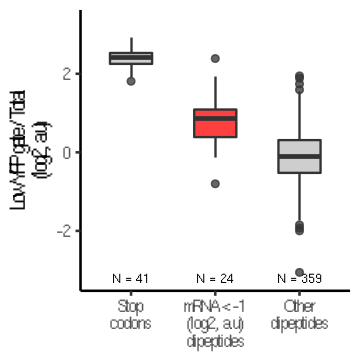

In [19]:
options(repr.plot.width=3, repr.plot.height=3)

xlabs <- c("Stop\ncodons", "mRNA < -1\n(log2, a.u)\ndipeptides", "Other\ndipeptides")

plot_data_4 %>% 
  ggplot(aes(x = fct_rev(type), y = lfc, fill = type)) +
  geom_boxplot(width = 0.5, alpha = 0.75, size = 0.5, height = 0) +
  geom_text(aes(label = n, x = type), y = -3.2, data = label_data, size = 2.5) +
  scale_fill_manual(values=c("grey", "#FF0000", "grey" )) +
  scale_y_continuous(limits = c(-3.2, 3.3)) +
  scale_x_discrete(labels= xlabs) +
  # Tests for all three comparisons
  # ggpubr::stat_compare_means(comparisons = list(c(1,2), c(1,3), c(2,3)), size = 2, label.y = c(3.75, 4.5, 3.25)) +
  theme(legend.position = "none", axis.title.x = element_text(margin = margin(t = 4), size = 10)) +
  labs(x = NULL, y = "Low YFP gate / Total\n(log2, a.u)") +
  NULL

# ggsave("../figures/20220228_insert_bin_enrichment.pdf")

## Add RH, VK, SF points to boxplot

# A tibble: 424 × 4
   diaa  lfc_mrna   lfc type 
   <chr>    <dbl> <dbl> <fct>
 1 *W     -0.920   2.93 Stop 
 2 F*      0.0892  2.77 Stop 
 3 *Q     -0.969   2.58 Stop 
 4 *F     -0.144   2.58 Stop 
 5 N*     -0.922   2.63 Stop 
 6 *N     -0.686   2.64 Stop 
 7 *Y     -0.523   2.59 Stop 
 8 *P      0.0518  2.62 Stop 
 9 *L     -0.513   2.64 Stop 
10 *C     -0.864   2.49 Stop 
# … with 414 more rows
# A tibble: 3 × 4
  diaa  lfc_mrna   lfc type    
  <chr>    <dbl> <dbl> <fct>   
1 RH       -2.66 1.35  Unstable
2 SF       -1.36 1.37  Unstable
3 VK       -2.26 0.907 Unstable


Warning message:
“Ignoring unknown parameters: height”


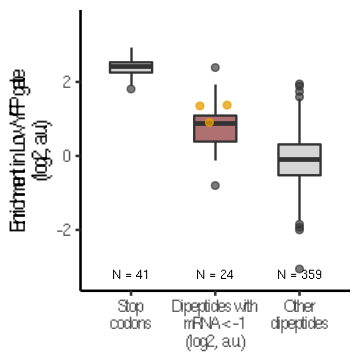

In [25]:
options(repr.plot.width=3, repr.plot.height=3)

xlabs <- c("Stop\ncodons", "Dipeptides with\nmRNA < -1\n(log2, a.u.)", "Other\ndipeptides")

highlight_data <- plot_data_4 %>% print %>% 
  filter(str_detect(diaa, "RH|VK|SF")) %>% print 


plot_data_4 %>% 
  ggplot(aes(x = fct_rev(type), y = lfc, fill = type)) +
  geom_boxplot(width = 0.5, alpha = 0.65, size = 0.5, height = 0) +
  geom_text(aes(label = n, x = type), y = -3.2, data = label_data, size = 2.5) +
  geom_jitter(data = highlight_data, aes(x = fct_rev(type), y = lfc), height = 0, width = 0.25, color = "#E69F00", alpha = 0.75)+
  scale_fill_manual(values=c("grey", "#832424", "grey" )) +
  scale_y_continuous(limits = c(-3.3, 3.6)) +
  scale_x_discrete(labels= xlabs) +
  # Tests for all three comparisons
  # ggpubr::stat_compare_means(comparisons = list(c(1,2), c(1,3), c(2,3)), size = 2, label.y = c(3.75, 4.5, 3.25)) +
  #Probably don't need to include stop comparisons. Use line below to omit these
  # ggpubr::stat_compare_means(comparisons = list(c(2,3)), size = 2.5, label.y = 3.0, alpha = 0.75) +
  theme(legend.position = "none", axis.title.x = element_text(margin = margin(t = 4), size = 10)) +
  labs(x = NULL, y = "Enrichment in Low YFP gate\n(log2, a.u.)") +
  NULL

# ggsave("../figures/20220301_insert_bin_enrichment.pdf")
